In [1]:
Experiments_file='/home/kate/Research/YearBuilt/Experiments/DwellingExperiments.xlsx'
AllExperiments_tab='Experiments'
Experiment_name='FWaterClaims'
#Experiment configuration: differenet datasets to try
#each line in the file contains the model name and set of features to built a dataset for SageMaker
Experiment_tab='%s InputData'%Experiment_name


Trial_name='%s-TrainingModels'%Experiment_name 



#model in
bucket='kdproperty'

#model parameters
hyperparameters = {
'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'silent': True,
        'booster': 'gbtree',
        'seed': 42,
        'scale_pos_weight':0.3,
        'colsample_bylevel': 0.8,
        'colsample_bytree': 0.8,
        'eta': 0.03,
        'max_depth': 4,
        'num_round':'5000'
}
#instance type to be created for training jobs. 
instance_type='ml.c5.xlarge'
#Script to be load in training instance
training_job_entry_point='ModelTraining.py'
#data in training and testing file type
content_type='text/csv'

In [2]:
#packages used in the notebook
import time
import sys
import sagemaker
from sagemaker.session import s3_input
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.xgboost.model import XGBoostModel
import pandas as pd
import numpy as np
from sagemaker.analytics import ExperimentAnalytics

In [3]:
#should be run as a first step
#role arn is used when run from a local machine
role = 'arn:aws:iam::757107622481:role/service-role/AmazonSageMaker-ExecutionRole-20200819T131882'
region = 'us-west-2'
sagemaker_session = sagemaker.session.Session(default_bucket=bucket)

In [4]:
models = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_tab)
models

,Model,Trial Component,Training_data,Validation_data
0,FWaterClaims,FWaterClaims-PreparingTrainValidData-FWaterClaims,s3://kdproperty/Data/training_data/FWaterClaims,s3://kdproperty/Data/validation_data/FWaterClaims


In [5]:
sys.path.append('/home/kate/Research/YearBuilt/Notebooks/Property')
import ExperimentsUtils as eu

In [6]:
experiments = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=AllExperiments_tab)

In [7]:
#delete experiment and trials but not output files associated with jobs in experiments
#eu.cleanup_experiment(Experiment_name)
eu.cleanup_trial(Experiment_name, Trial_name)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [8]:
eu.create_experiment(Experiment_name)
eu.create_trial(Experiment_name,Trial_name)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [9]:
%%writefile ModelTraining.py

#  Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License").
#  You may not use this file except in compliance with the License.
#  A copy of the License is located at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  or in the "license" file accompanying this file. This file is distributed
#  on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#  express or implied. See the License for the specific language governing
#  permissions and limitations under the License.
from __future__ import print_function

import argparse
import json
import logging
import os
import pandas as pd
import pickle as pkl

from sagemaker_containers import entry_point
from sagemaker_xgboost_container.data_utils import get_dmatrix
from sagemaker_xgboost_container import distributed

import xgboost as xgb

import pandas as pd
import numpy as np



def _xgb_train(params, dtrain, evals, num_boost_round, model_dir, is_master):
    """Run xgb train on arguments given with rabit initialized.

    This is our rabit execution function.

    :param args_dict: Argument dictionary used to run xgb.train().
    :param is_master: True if current node is master host in distributed training,
                        or is running single node training job.
                        Note that rabit_run will include this argument.
    """
    booster = xgb.train(params=params,
                        dtrain=dtrain,
                        evals=evals,
                        maximize=True,
                        num_boost_round=num_boost_round,
                        early_stopping_rounds=100,
                        verbose_eval=100)

    if is_master:
        model_location = model_dir + '/xgboost-model'
        pkl.dump(booster, open(model_location, 'wb'))
        logging.info("Stored trained model at {}".format(model_location))


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here.
    parser.add_argument('--max_depth', type=int,)
    parser.add_argument('--eta', type=float)
    parser.add_argument('--objective', type=str)
    parser.add_argument('--num_round', type=int)
    
    parser.add_argument('--eval_metric', type=str)
    parser.add_argument('--seed', type=float)
    parser.add_argument('--scale_pos_weight', type=float)
    parser.add_argument('--colsample_bylevel', type=float)
    parser.add_argument('--colsample_bytree', type=float)
        
            
            

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output_data_dir', type=str, default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    parser.add_argument('--sm_hosts', type=str, default=os.environ.get('SM_HOSTS'))
    parser.add_argument('--sm_current_host', type=str, default=os.environ.get('SM_CURRENT_HOST'))

    args, _ = parser.parse_known_args()

    # Get SageMaker host information from runtime environment variables
    sm_hosts = json.loads(args.sm_hosts)
    sm_current_host = args.sm_current_host

    dtrain = get_dmatrix(args.train, 'csv')
    dval = get_dmatrix(args.validation, 'csv')
    watchlist = [(dtrain, 'train'), (dval, 'validation')] if dval is not None else [(dtrain, 'train')]

    
    
    train_hp = {
        'max_depth': args.max_depth,
        'eta': args.eta,
        'objective': args.objective,
        'silent': True,
        'booster': 'gbtree',
        'seed': 42,
        'eval_metric':args.eval_metric,
        'scale_pos_weight':args.scale_pos_weight,
        'colsample_bylevel': args.colsample_bylevel,
        'colsample_bytree': args.colsample_bytree
        }

    xgb_train_args = dict(
        params=train_hp,
        dtrain=dtrain,
        evals=watchlist,
        num_boost_round=args.num_round,
        model_dir=args.model_dir)

    if len(sm_hosts) > 1:
        # Wait until all hosts are able to find each other
        entry_point._wait_hostname_resolution()

        # Execute training function after initializing rabit.
        distributed.rabit_run(
            exec_fun=_xgb_train,
            args=xgb_train_args,
            include_in_training=(dtrain is not None),
            hosts=sm_hosts,
            current_host=sm_current_host,
            update_rabit_args=True
        )
    else:
        # If single node training, call training method directly.
        if dtrain:
            xgb_train_args['is_master'] = True
            _xgb_train(**xgb_train_args)
        else:
            raise ValueError("Training channel must have data to train model.")


def model_fn(model_dir):
    """Deserialize and return fitted model.

    Note that this should have the same name as the serialized model in the _xgb_train method
    """
    model_file = 'xgboost-model'
    booster = pkl.load(open(os.path.join(model_dir, model_file), 'rb'))
    return booster

Overwriting ModelTraining.py


In [10]:

processors=list()

for index, row in models.iterrows():
    model=row['Model']
    print (index, ': Training model %s'%model)
    print(row['Training_data'])
    print(row['Validation_data'])
    train_input = s3_input(row['Training_data'], content_type=content_type)
    validation_input = s3_input(row['Validation_data'], content_type=content_type)
                               
    xgb_script_mode_estimator = XGBoost(
        entry_point=training_job_entry_point,
        hyperparameters=hyperparameters,
        role=role, 
        train_instance_count=1,
        train_instance_type=instance_type,
        framework_version="1.0-1",
        output_path='s3://%s'%(bucket)
        )
    #Training
    job_name=model.replace('_','-') +'-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
    xgb_script_mode_estimator.fit({'train': train_input, 'validation': validation_input}, job_name=job_name, wait=False,
    experiment_config = {
        'ExperimentName': Experiment_name ,
        'TrialName' : Trial_name,
        'TrialComponentDisplayName' : '%s-%s'%(Trial_name,model.replace('_','-')),})
    # to prevent throttling
    time.sleep(.5)
    processors.append(xgb_script_mode_estimator)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


0 : Training model FWaterClaims
s3://kdproperty/Data/training_data/FWaterClaims
s3://kdproperty/Data/validation_data/FWaterClaims


INFO:sagemaker:Creating training-job with name: FWaterClaims-2020-12-31-20-15-33


In [11]:
eu.wait_training_jobs(processors=processors,check_every_sec=10,print_every_n_output=6,wait_min=60)

Training job FWaterClaims-2020-12-31-20-15-33 status: InProgress
Continue waiting...
Training job FWaterClaims-2020-12-31-20-15-33 status: InProgress
Continue waiting...
Training job FWaterClaims-2020-12-31-20-15-33 status: InProgress
Continue waiting...
Training job FWaterClaims-2020-12-31-20-15-33 status: InProgress
Continue waiting...
All Training Jobs are Completed


In [19]:
trial_component_analytics = ExperimentAnalytics(
    experiment_name=Experiment_name   
)
trial_comp_ds = trial_component_analytics.dataframe()
trial_ds=trial_comp_ds[trial_comp_ds['DisplayName'].str.contains(Trial_name)].copy()
trial_ds['Model']=trial_ds['DisplayName'].str.replace(Trial_name+'-','')
trial_ds['Model']=trial_ds['Model'].str.replace('-','_')

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [13]:
#hyperparameters used in models
ModelsParams = trial_ds[['Model','DisplayName',
                                                                      'objective', 
                                                                      'eval_metric', 
                                                                      'silent',  
                                                                      'booster', 
                                                                      'seed',
                                                                      'scale_pos_weight', 
                                                                      'colsample_bylevel',
                                                                      'colsample_bytree',
                                                                      'eta',
                                                                      'max_depth', 
                                                                      'num_round']]
ModelsParams.columns=['Model','Trial Component',
                                                                      'objective', 
                                                                      'eval_metric', 
                                                                      'silent',  
                                                                      'booster', 
                                                                      'seed',
                                                                      'scale_pos_weight', 
                                                                      'colsample_bylevel',
                                                                      'colsample_bytree',
                                                                      'eta',
                                                                      'max_depth', 
                                                                      'num_round']
ModelsParams

,Model,Trial Component,objective,eval_metric,silent,booster,seed,scale_pos_weight,colsample_bylevel,colsample_bytree,eta,max_depth,num_round
0,FWaterClaims,FWaterClaims-TrainingModels-FWaterClaims,"""binary:logistic""","""auc""",true,"""gbtree""",42.0,0.3,0.8,0.8,0.03,4.0,"""5000"""


In [14]:
#Saving into the Experiment log file models hyperparameters used
eu.SaveToExperimentLog(Experiments_file, '%s ModelParams'%Experiment_name, ModelsParams)

In [15]:
ModelsResults = trial_ds[['Model','DisplayName','train:auc - Last','validation:auc - Last']].sort_values('validation:auc - Last', ascending=False)
ModelsResults.columns=['Model','Trial Component','train:auc','validation:auc']
ModelsResults

,Model,Trial Component,train:auc,validation:auc
0,FWaterClaims,FWaterClaims-TrainingModels-FWaterClaims,0.73235,0.67848


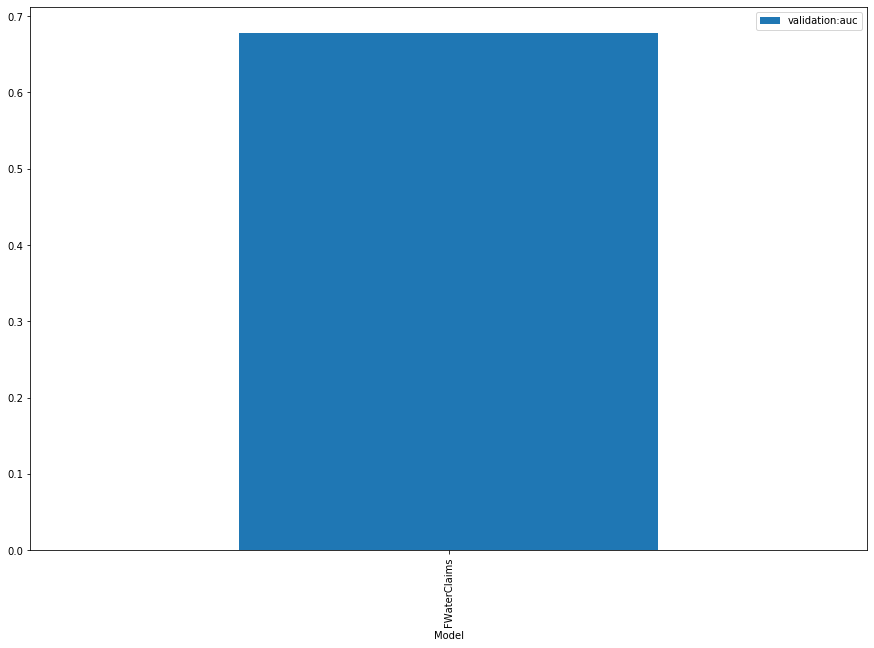

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches([15, 10])
ModelsResults.plot.bar('Model', 'validation:auc',ax=plt.gca())

In [17]:
#Saving into the Experiment log file models results
eu.SaveToExperimentLog(Experiments_file, '%s ModelResults'%Experiment_name, ModelsResults)

In [20]:
ModelsFiles = trial_ds[['Model','DisplayName','SageMaker.ModelArtifact - Value']]
ModelsFiles.columns=['Model','Trial Component','ModelData']
ModelsFiles

,Model,Trial Component,ModelData
0,FWaterClaims,FWaterClaims-TrainingModels-FWaterClaims,s3://kdproperty/FWaterClaims-2020-12-31-20-15-...


In [21]:
#Saving into the Experiment log file models files
eu.SaveToExperimentLog(Experiments_file, '%s ModelFiles'%Experiment_name, ModelsFiles)